#**Tugas Besar Pengenalan Pola**

#**Nifelling Rosmelia Sandewa (21110014)**

#**Gavrilla Claudia (21110004)**

# Install & Import Library

In [ ]:
pip install Augmentor

In [ ]:
pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 

In [ ]:
pip install tensorflow

In [ ]:
# Import library
import os
import shutil
import Augmentor
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from roboflow import Roboflow
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Download Data

In [ ]:
# MEN-DOWNLOAD DATA GAMBAR DARI WEBSITE ROBOFLOW
rf = Roboflow(api_key="2yyTa5bFV98tZ0imdu9l")
project = rf.workspace("new-workspace-7ly0p").project("durian-diseases")
dataset = project.version(5).download("multiclass")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Durian-Diseases-5 in multiclass:: 100%|██████████| 424/424 [00:00<00:00, 3871.60it/s]


# Pre Processing data

In [ ]:
# LOAD INFORMASI FILE DARI CSV Classes
csv_path = '/content/Durian-Diseases-5/train/_classes.csv'
df = pd.read_csv(csv_path, index_col='filename')
image_folder_path = '/content/Durian-Diseases-5/train/'

# MEMBUAT FOLDER BARU
output_folder = '/content/Leaf Durian Diseases'

# MEMBUAT SUBFOLDER CLASS
train_output_dir = os.path.join(output_folder, 'train')
validation_output_dir = os.path.join(output_folder, 'validation')
test_output_dir = os.path.join(output_folder, 'test')

os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(validation_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# RASIO PEMBAGIAN DATA
train_size = 0.48
test_size = 0.24
validation_size = 0.29

train_df, temp_df = train_test_split(df, test_size=(1 - train_size), random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=test_size/(test_size + validation_size), random_state=42)

print("Jumlah data pelatihan:", len(train_df))
print("Jumlah data pengujian:", len(test_df))
print("Jumlah data validasi:", len(validation_df))


# MEMINDAHKAN GAMBAR KE MASING-MASING SUBFOLDER CLASS
for index, row in df.iterrows():
    image_filename = index

    if index in train_df.index:
        output_dir = train_output_dir
    elif index in validation_df.index:
        output_dir = validation_output_dir
    else:
        output_dir = test_output_dir

    class_folder = os.path.join(output_dir, str(row.idxmax()))
    os.makedirs(class_folder, exist_ok=True)

    shutil.copy(os.path.join(image_folder_path, image_filename), os.path.join(class_folder, image_filename))


Jumlah data pelatihan: 201
Jumlah data pengujian: 100
Jumlah data validasi: 119


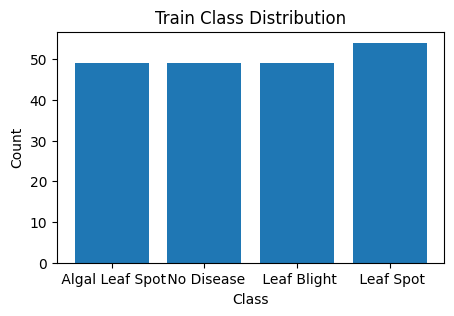

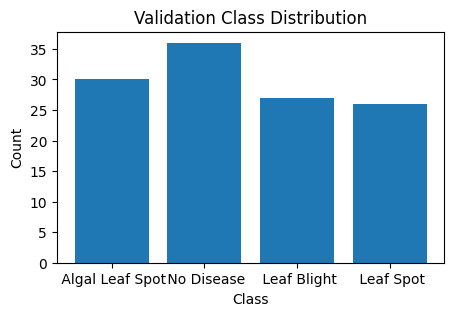

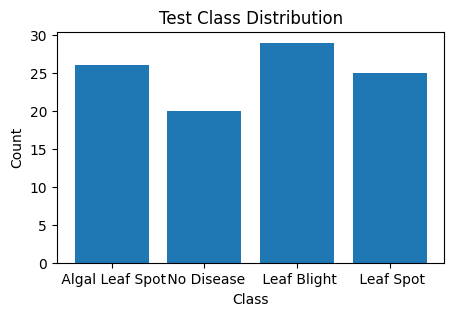

In [ ]:
# MENAMPILKAN DISTRIBUSI PADA TIAP FOLDER
def count_class_distribution(folder_path):
    class_distribution = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            class_count = len(os.listdir(class_folder))
            class_distribution[class_name] = class_count
    return class_distribution

output_folder = '/content/Leaf Durian Diseases'

train_distribution = count_class_distribution(os.path.join(output_folder, 'train'))
validation_distribution = count_class_distribution(os.path.join(output_folder, 'validation'))
test_distribution = count_class_distribution(os.path.join(output_folder, 'test'))

def plot_class_distribution(title, class_distribution):
    plt.figure(figsize=(5, 3))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution('Train Class Distribution', train_distribution)
plot_class_distribution('Validation Class Distribution', validation_distribution)
plot_class_distribution('Test Class Distribution', test_distribution)


# Data augmentation

In [ ]:
train_data_path = '/content/Leaf Durian Diseases/train/'

# INISIALISASI PIPELINE AUGMENTOR
pipeline = Augmentor.Pipeline(train_data_path, output_directory=train_data_path)

# PARAMETER AUGMENTOR
pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=20)
pipeline.flip_left_right(probability=0.5)
pipeline.flip_top_bottom(probability=0.5)
pipeline.random_distortion(probability=0.8, grid_width=4, grid_height=4, magnitude=8)
pipeline.shear(probability=0.6, max_shear_left=20, max_shear_right=20)
pipeline.crop_centre(probability=0.2, percentage_area=0.6)

# MENENTUKAN JUMLAH PRODUKSI GAMBAR AUGMENTASI
num_of_augmented_images = 1799

# RUNNING AUGMENTOR
pipeline.sample(num_of_augmented_images)


Initialised with 201 image(s) found.
Output directory set to /content/Leaf Durian Diseases/train/.

Processing <PIL.Image.Image image mode=RGB size=640x640 at 0x7D06DA7EDB70>: 100%|██████████| 1799/1799 [03:21<00:00,  8.95 Samples/s]


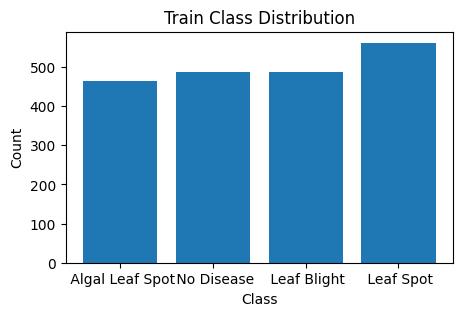

In [ ]:
# MENAMPILKAN DISTRIBUSI CLASS PADA FOLDER TRAIN
def count_class_distribution(folder_path):
    class_distribution = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            class_count = len(os.listdir(class_folder))
            class_distribution[class_name] = class_count
    return class_distribution

output_folder = '/content/Leaf Durian Diseases'
train_distribution = count_class_distribution(os.path.join(output_folder, 'train'))

def plot_class_distribution(title, class_distribution):
    plt.figure(figsize=(5, 3))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution('Train Class Distribution', train_distribution)

In [ ]:
# MENGHITUNG JUMLAH GAMBAR FOLDER TRAIN SETELAH AUGMENTASI
num_train_data = sum([len(files) for _, _, files in os.walk(train_data_path)])

print("Jumlah total data train setelah augmentasi:", num_train_data)

Jumlah total data train setelah augmentasi: 2000


In [ ]:
# MEMBUAT GENERATOR TRAIN, TEST, DAN VALIDATION
train_data_path = '/content/Leaf Durian Diseases/train/'
validation_data_path = '/content/Leaf Durian Diseases/validation/'
test_data_path = '/content/Leaf Durian Diseases/test/'

# TARGET SIZE IMAGE
img_size = (128, 128)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_data_path,
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
)

test_generator = datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 2000 images belonging to 4 classes.
Found 119 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


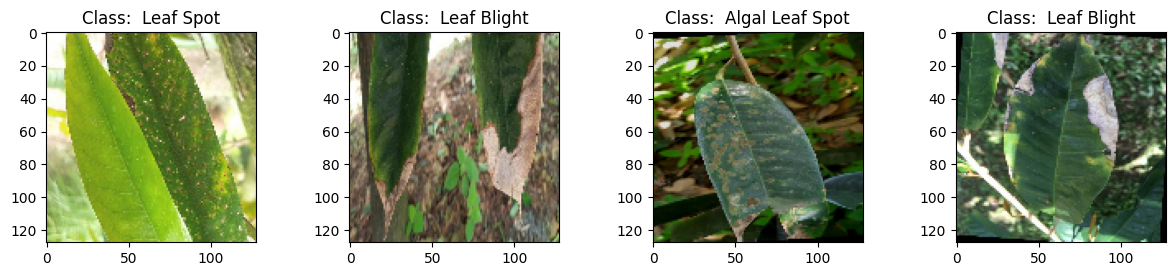

In [ ]:
import matplotlib.pyplot as plt

# MENAMPILKAN BEBERAPA SAMPLE GAMBAR TRAINING

num_images_to_display = 4

images, labels = train_generator.next()

class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 6))
for i in range(num_images_to_display):
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(images[i])

    label_index = labels[i].argmax()
    class_label = class_labels[label_index]

    plt.title(f"Class: {class_label}")

plt.show()


# Building the CNN Network

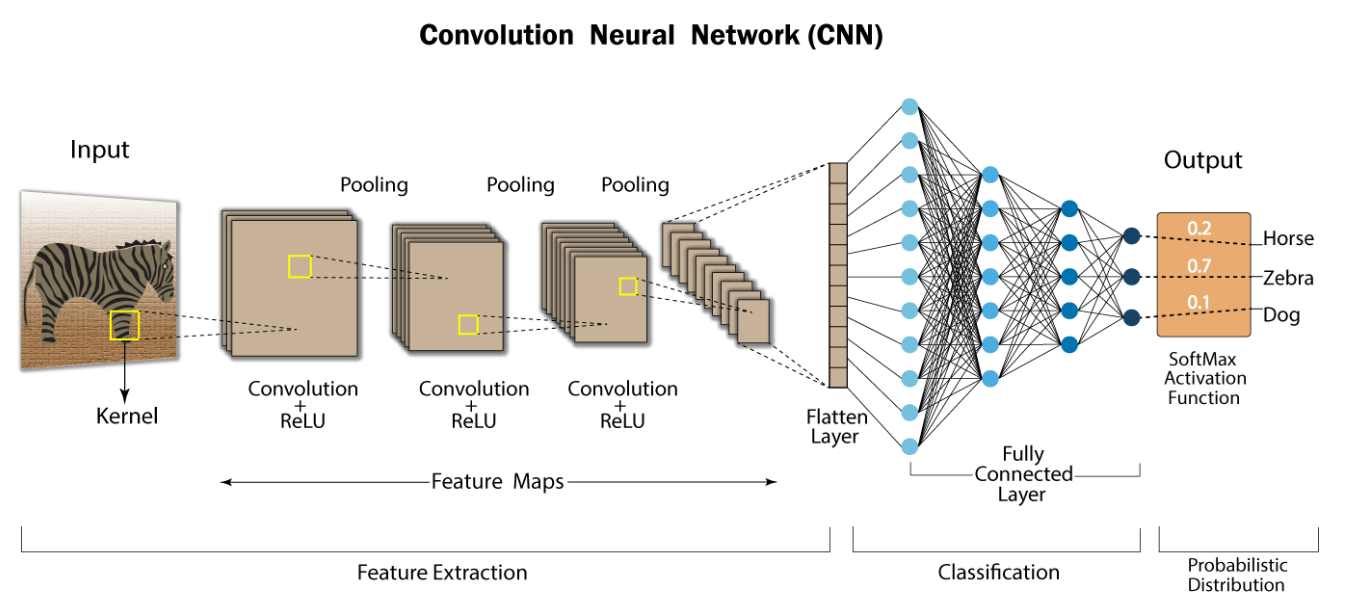

# Model InceptionV3 (Adam, Dense=128, lr=0.0001)

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

# INISIALISASI MODEL VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model = Sequential()
model.add(base_model)

# MENAMBAHKAN LAYER TAMBAHAN
model.add(GlobalAveragePooling2D())
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_36 (Dense)            (None, 96)                49248     
                                                                 
 dropout_43 (Dropout)        (None, 96)                0         
                                                                 
 dense_37 (Dense)            (None, 4)                 388       
                                                                 
Total params: 14764324 (56.32 MB)
Trainable params: 49636 (193.89 KB)
Non-trainable params: 14714688 (56.13 MB)
_______

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [ ]:
# MELATIH MODEL VGG16
history_2b = model.fit(
    train_generator,
    epochs=75,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    batch_size=16
)

Epoch 1/75
125/125 [==============================] - 9s 60ms/step - loss: 1.4948 - accuracy: 0.3065 - val_loss: 1.2239 - val_accuracy: 0.5378 - lr: 1.0000e-04
Epoch 2/75
125/125 [==============================] - 7s 53ms/step - loss: 1.2876 - accuracy: 0.3990 - val_loss: 1.1463 - val_accuracy: 0.5378 - lr: 1.0000e-04
Epoch 3/75
125/125 [==============================] - 7s 55ms/step - loss: 1.1565 - accuracy: 0.5015 - val_loss: 1.0859 - val_accuracy: 0.5546 - lr: 1.0000e-04
Epoch 4/75
125/125 [==============================] - 7s 59ms/step - loss: 1.0982 - accuracy: 0.5320 - val_loss: 1.0551 - val_accuracy: 0.5462 - lr: 1.0000e-04
Epoch 5/75
125/125 [==============================] - 6s 50ms/step - loss: 1.0321 - accuracy: 0.5635 - val_loss: 1.0258 - val_accuracy: 0.5882 - lr: 1.0000e-04
Epoch 6/75
125/125 [==============================] - 8s 60ms/step - loss: 1.0109 - accuracy: 0.5805 - val_loss: 1.0056 - val_accuracy: 0.5882 - lr: 1.0000e-04
Epoch 7/75
125/125 [====================

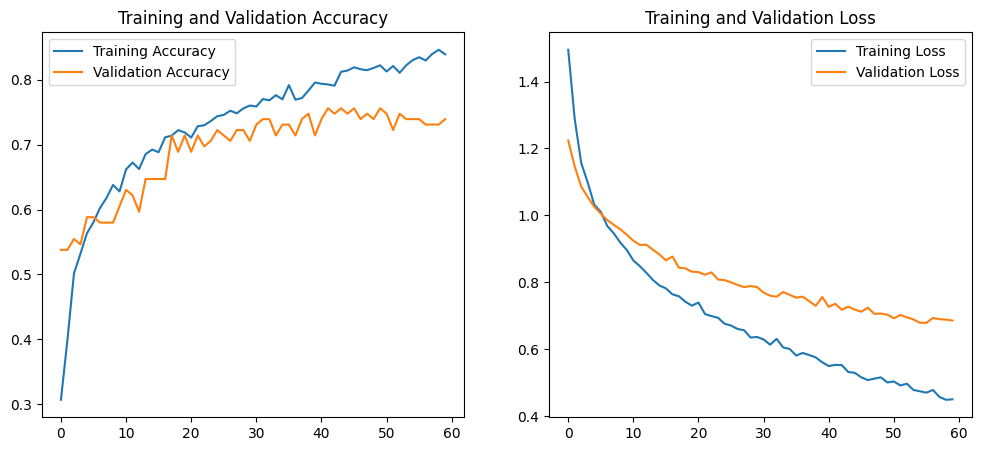

In [ ]:
import matplotlib.pyplot as plt

# MENGAMBIL METRIK TRAINING
acc = history_2b.history['accuracy']
loss = history_2b.history['loss']

# MENGAMBIL METRIK VALIDASI
val_acc = history_2b.history['val_accuracy']
val_loss = history_2b.history['val_loss']

# PLOT GRAFIK AKURASI
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# PLOT GRAFIK LOSS
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


7/7 [==============================] - 1s 50ms/step


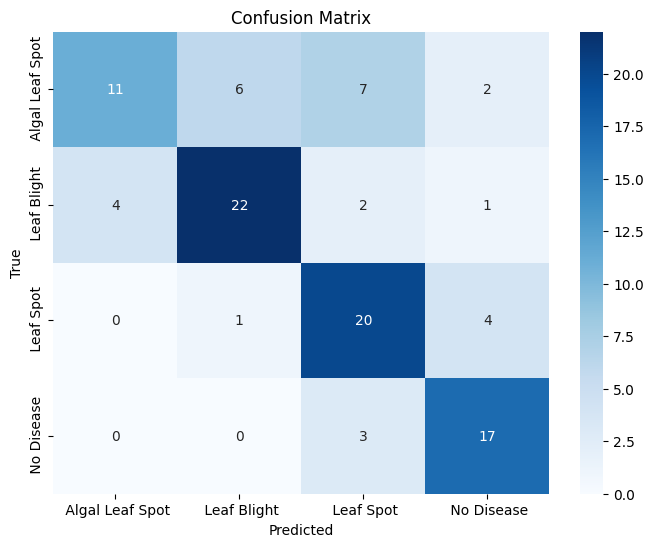

In [ ]:
from sklearn.metrics import confusion_matrix

# MENDAPATKAN HASIL PREDIKSI MODEL DARI DATA TEST
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 37ms/step


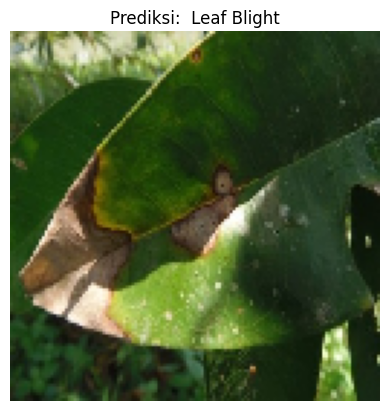

In [ ]:
# MELAKUKAN PREDIKSI GAMBAR ALGAF LEAF SPOT MENGGUNAKAN GAMBAR DARI LUAR DATASET
img_path = '/content/Leaf Blight Pred.jpg'
img = image.load_img(img_path, target_size=(128, 128))

img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

label_map = train_generator.class_indices
labels = dict((v, k) for k, v in label_map.items())
predicted_label = labels[predicted_class]

plt.imshow(img)
plt.axis('off')
plt.title(f'Prediksi: {predicted_label}')
plt.show()


1/1 [==============================] - 0s 219ms/step


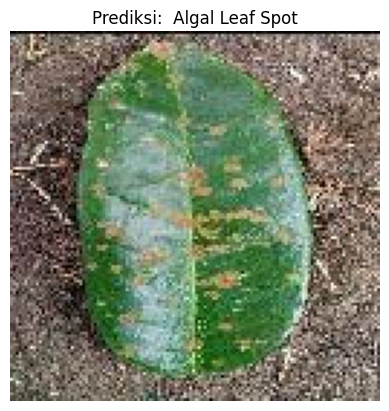

In [ ]:
# MELAKUKAN PREDIKSI GAMBAR LEAF BLIGHT MENGGUNAKAN GAMBAR DARI LUAR DATASET
img_path = '/content/Algaf Spot Pred.jpeg'
img = image.load_img(img_path, target_size=(128, 128))

img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

label_map = train_generator.class_indices
labels = dict((v, k) for k, v in label_map.items())
predicted_label = labels[predicted_class]

plt.imshow(img)
plt.axis('off')
plt.title(f'Prediksi: {predicted_label}')
plt.show()


# Model CNN (4 Layer Conv2D, (16, 32, 64, 64), Dense=128, lr=0.0001)

In [ ]:
# MEMBUAT MODEL CNN
model_1an = Sequential()

# LAYER 1
model_1an.add(Conv2D(16, (3, 3), activation='relu', padding='Same', input_shape=(128, 128, 3)))
model_1an.add(MaxPooling2D(pool_size=(2, 2)))
model_1an.add(Dropout(0.25))

# LAYER 2
model_1an.add(Conv2D(32, (3, 3), padding='Same', activation='relu'))
model_1an.add(MaxPooling2D(pool_size=(2, 2)))
model_1an.add(Dropout(0.25))

# LAYER 3
model_1an.add(Conv2D(32, (3, 3), padding='Same', activation='relu'))
model_1an.add(MaxPooling2D(pool_size=(2, 2)))
model_1an.add(Dropout(0.25))

# LAYER 4
model_1an.add(Conv2D(64, (3, 3), padding='Same', activation='relu'))
model_1an.add(MaxPooling2D(pool_size=(2, 2)))
model_1an.add(Dropout(0.25))

model_1an.add(Flatten())

# FULLY CONNECTED LAYER 1
model_1an.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_1an.add(Dropout(0.5))

# FULLY CONNECTED LAYER 2 (output layer)
model_1an.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model_1an.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_1an.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_961 (Conv2D)         (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 64, 64, 16)        0         
                                                                 
 conv2d_962 (Conv2D)         (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 32, 32, 32)      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [ ]:
# TRAINING MODEL
history_1an = model_1an.fit(
    train_generator,
    epochs=65,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True,
    batch_size=16
)

Epoch 1/65
125/125 [==============================] - 10s 60ms/step - loss: 2.5756 - accuracy: 0.2740 - val_loss: 2.4135 - val_accuracy: 0.2353 - lr: 1.0000e-04
Epoch 2/65
125/125 [==============================] - 6s 49ms/step - loss: 2.2865 - accuracy: 0.2780 - val_loss: 2.1831 - val_accuracy: 0.2185 - lr: 1.0000e-04
Epoch 3/65
125/125 [==============================] - 7s 56ms/step - loss: 2.0838 - accuracy: 0.2950 - val_loss: 2.0140 - val_accuracy: 0.2185 - lr: 1.0000e-04
Epoch 4/65
125/125 [==============================] - 6s 46ms/step - loss: 1.9352 - accuracy: 0.3240 - val_loss: 1.8919 - val_accuracy: 0.2605 - lr: 1.0000e-04
Epoch 5/65
125/125 [==============================] - 6s 49ms/step - loss: 1.8255 - accuracy: 0.3455 - val_loss: 1.8032 - val_accuracy: 0.2857 - lr: 1.0000e-04
Epoch 6/65
125/125 [==============================] - 7s 59ms/step - loss: 1.7230 - accuracy: 0.3835 - val_loss: 1.7461 - val_accuracy: 0.2521 - lr: 1.0000e-04
Epoch 7/65
125/125 [===================

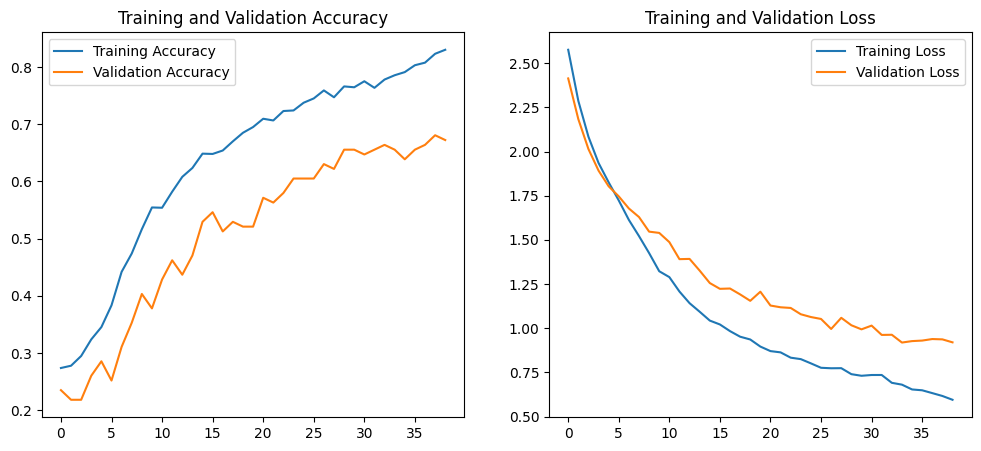

In [ ]:
import matplotlib.pyplot as plt

acc = history_1an.history['accuracy']
loss = history_1an.history['loss']

val_acc = history_1an.history['val_accuracy']
val_loss = history_1an.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


7/7 [==============================] - 0s 49ms/step


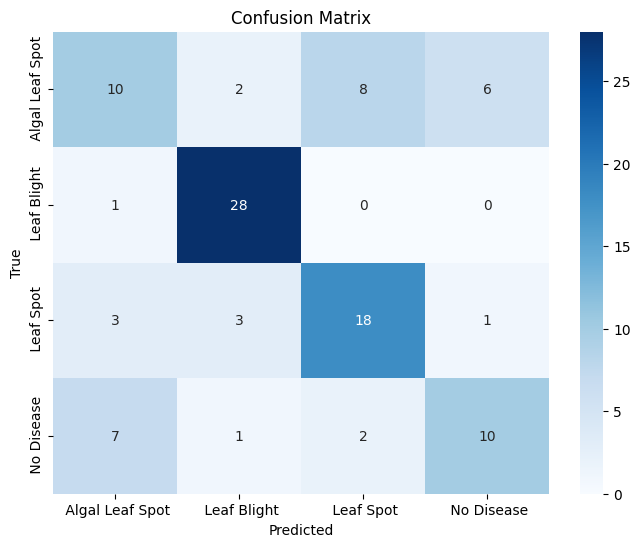

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model_1an.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 129ms/step


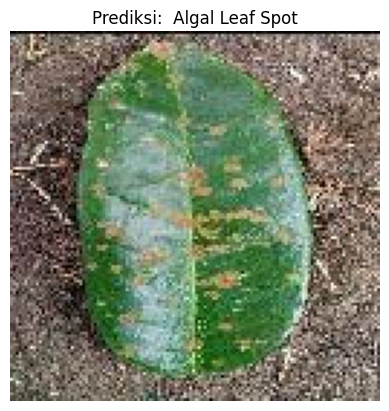

In [ ]:
img_path = '/content/Algaf Spot Pred.jpeg'
img = image.load_img(img_path, target_size=(128, 128))

img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model_1an.predict(img_array)
predicted_class = np.argmax(prediction)

label_map = train_generator.class_indices
labels = dict((v, k) for k, v in label_map.items())
predicted_label = labels[predicted_class]

plt.imshow(img)
plt.axis('off')
plt.title(f'Prediksi: {predicted_label}')
plt.show()


1/1 [==============================] - 0s 24ms/step


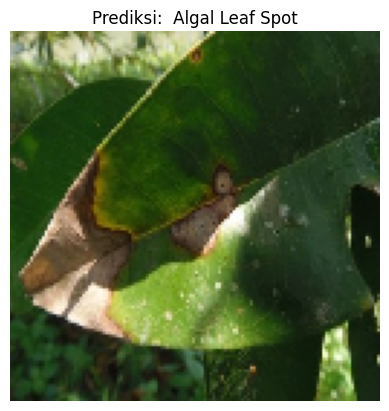

In [ ]:
img_path = '/content/Leaf Blight Pred.jpg'
img = image.load_img(img_path, target_size=(128, 128))

img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model_1an.predict(img_array)
predicted_class = np.argmax(prediction)

label_map = train_generator.class_indices
labels = dict((v, k) for k, v in label_map.items())
predicted_label = labels[predicted_class]

plt.imshow(img)
plt.axis('off')
plt.title(f'Prediksi: {predicted_label}')
plt.show()


# Model 1A

In [ ]:
# Inisialisasi model
model = Sequential()

# Layer Konvolusi pertama
model.add(Conv2D(16, (3, 3), activation='relu', padding='Same', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Layer Konvolusi kedua
model.add(Conv2D(32, (3, 3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Flatten layer
model.add(Flatten())

# Fully connected layer pertama
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

# Fully connected layer kedua (output layer)
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

# Compile model
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan summary model
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_43 (Dropout)        (None, 32, 32, 16)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 16, 16, 32)      

In [ ]:
# Melatih model
history = model.fit(train_generator, epochs=75, validation_data=validation_generator)

Epoch 1/75
25/25 [==============================] - 8s 274ms/step - loss: 7.9484 - accuracy: 0.2937 - val_loss: 4.9905 - val_accuracy: 0.4603
Epoch 2/75
25/25 [==============================] - 6s 220ms/step - loss: 3.6746 - accuracy: 0.4038 - val_loss: 2.7380 - val_accuracy: 0.3333
Epoch 3/75
25/25 [==============================] - 5s 215ms/step - loss: 2.2465 - accuracy: 0.4675 - val_loss: 1.8965 - val_accuracy: 0.5714
Epoch 4/75
25/25 [==============================] - 7s 286ms/step - loss: 1.6871 - accuracy: 0.5525 - val_loss: 1.6961 - val_accuracy: 0.4603
Epoch 5/75
25/25 [==============================] - 6s 217ms/step - loss: 1.5034 - accuracy: 0.5663 - val_loss: 1.4583 - val_accuracy: 0.5714
Epoch 6/75
25/25 [==============================] - 6s 252ms/step - loss: 1.4120 - accuracy: 0.5763 - val_loss: 1.5755 - val_accuracy: 0.5556
Epoch 7/75
25/25 [==============================] - 6s 219ms/step - loss: 1.3838 - accuracy: 0.5788 - val_loss: 1.4428 - val_accuracy: 0.5873
Epoch 

# non-necessary

In [ ]:
import shutil

def delete_folder(folder_path):
    try:
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' berhasil dihapus.")
    except OSError as e:
        print(f"Error: {folder_path} : {e.strerror}")

# Contoh penggunaan
folder_path_to_delete = '/content/Durian-Diseases-5'
delete_folder(folder_path_to_delete)


Folder '/content/Durian-Diseases-5' berhasil dihapus.


In [ ]:
import shutil

def delete_folder(folder_path):
    try:
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' berhasil dihapus.")
    except OSError as e:
        print(f"Error: {folder_path} : {e.strerror}")

# Contoh penggunaan
folder_path_to_delete = '/content/Leaf Durian Diseases'
delete_folder(folder_path_to_delete)


Folder '/content/Leaf Durian Diseases' berhasil dihapus.


In [ ]:
# Tentukan path ke folder validation
validation_data_path = '/content/Leaf Durian Diseases/validation/'

# Inisialisasi pipeline Augmentor dengan direktori output sesuai dengan struktur folder validation
pipeline = Augmentor.Pipeline(validation_data_path, output_directory=validation_data_path)

# Tambahkan operasi augmentasi ke dalam pipeline sesuai kebutuhan
pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=20)
pipeline.flip_left_right(probability=0.5)
pipeline.flip_top_bottom(probability=0.5)
pipeline.random_distortion(probability=0.8, grid_width=4, grid_height=4, magnitude=8)

# Tentukan jumlah gambar hasil augmentasi yang ingin dihasilkan
num_of_augmented_images = 281

# Jalankan augmentasi
pipeline.sample(num_of_augmented_images)


Initialised with 119 image(s) found.
Output directory set to /content/Leaf Durian Diseases/validation/.

Processing <PIL.Image.Image image mode=RGB size=640x640 at 0x7C9F743E1960>: 100%|██████████| 281/281 [00:24<00:00, 11.43 Samples/s]


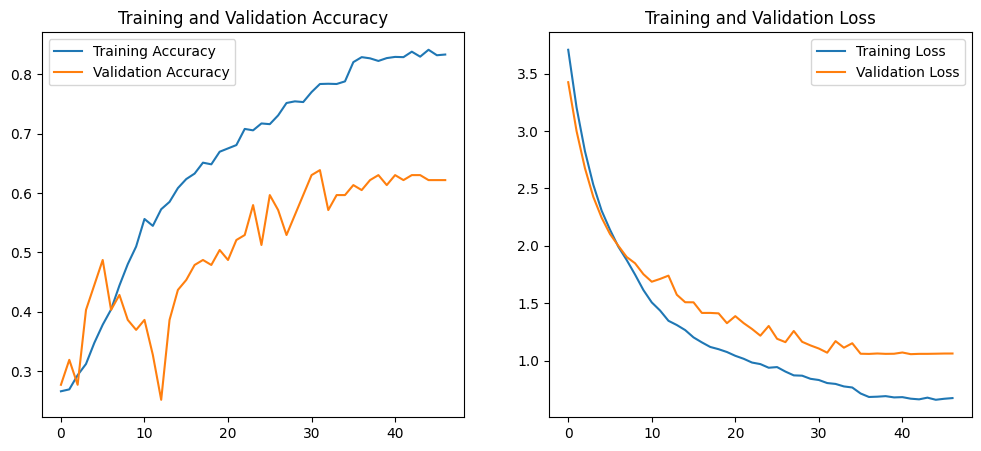

In [ ]:
import matplotlib.pyplot as plt

# Ambil metrik pelatihan
acc = history_1an.history['accuracy']
loss = history_1an.history['loss']

# Ambil metrik validasi
val_acc = history_1an.history['val_accuracy']
val_loss = history_1an.history['val_loss']

# Plot grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot grafik loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


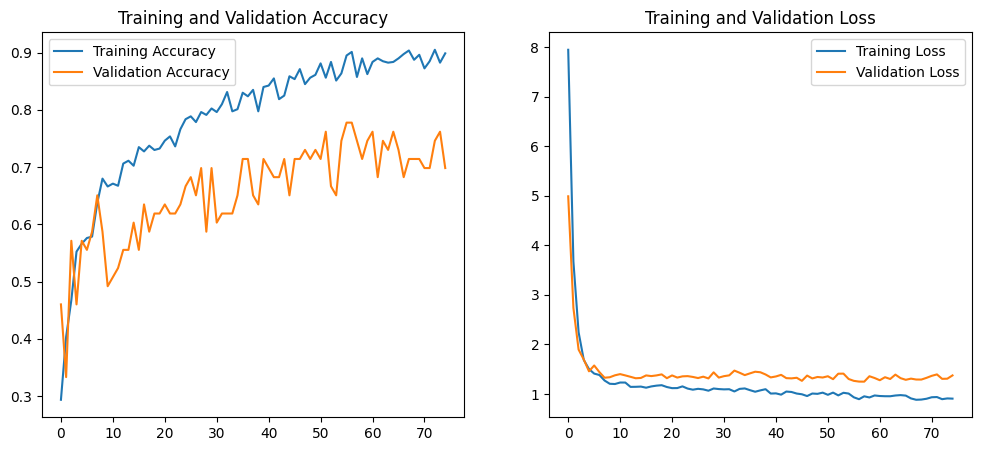

In [ ]:
import matplotlib.pyplot as plt

# Ambil metrik pelatihan
acc = history.history['accuracy']
loss = history.history['loss']

# Ambil metrik validasi
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot grafik loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


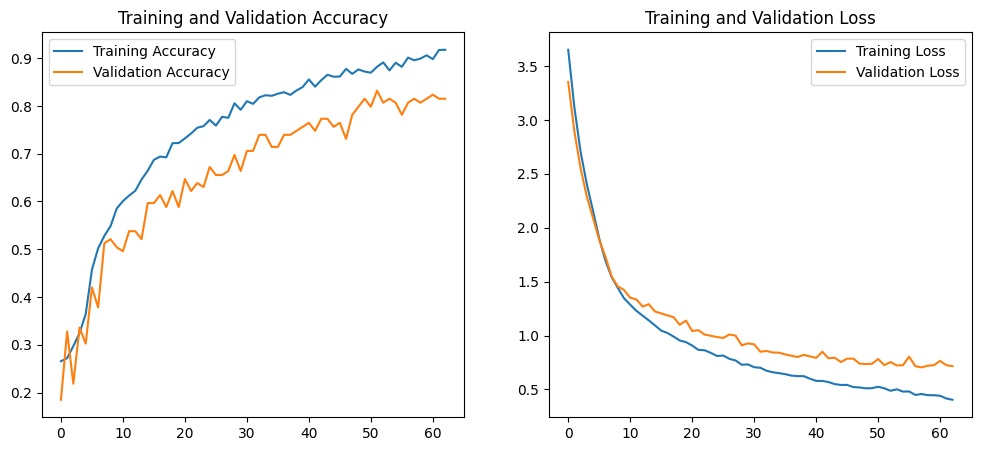

In [ ]:
import matplotlib.pyplot as plt

# Ambil metrik pelatihan
acc = history_1an.history['accuracy']
loss = history_1an.history['loss']

# Ambil metrik validasi
val_acc = history_1an.history['val_accuracy']
val_loss = history_1an.history['val_loss']

# Plot grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot grafik loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()
